# Clustering NHL Forwards by Game Statistics

In this study we will use unsupervised learning techniques to attempt to cluster ice hockey forwards from the National Hockey League into groups based on their in-game statistics from the 2023-24 season. We will analyze the statistics of each group's players and assign a label and description to the players. By using unsupervised learning we hope to uncover natural groupings of players based on their statistics.

The data set used is from the website Natural Stat Trick, a site dedicated to statistical analysis of NHL players and teams. The data was retrieved in csv format and a [link](https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=S&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL) to the data can be found in the Reference section. The references also contain a link to a GitHub repository for this project.

The raw data contains 35 features. Not all of these features will be used for our analysis, however so we will save a description of the relevant features for our Data Cleaning section. The 35 features in the data source are 'Unnamed: 0, Player, Team, Position, GP, TOI, Goals, Total Assists, First Assists, Second Assists, Total Points, IPP, Shots, SH%, ixG, iCF, iFF, iSCF, iHDCF, Rush Attempts, Rebounds Created, PIM, Total Penalties, Minor, Major, Misconduct, Penalties Drawn, Giveaways, Takeaways, Hits, Hits Taken, Shots Blocked, Faceoffs Won, Faceoffs Lost, and Faceoffs %'.

## Import modules and functions

In [150]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import v_measure_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer
from scipy.optimize import linear_sum_assignment

import os
os.environ['LOKY_MAX_CPU_COUNT'] = '8'

## Data Import and Cleaning

From an initial inspection of the data, we can see that it contains 924 player entries with 35 features each. Excluding the index, Player, Team, and Position columns, which are there to identify the player, there are 31 numeric columns we can use to cluster players.

These 31 features contain a number of statistics, both traditional and some more advanced statistics. Although we will not use all of the features in our final model, we will clean and prepare them all for analysis so that we can easily add or remove them from our model later.

In [151]:
player_df = pd.read_csv('data/2023-24 Basic Stats.csv')

player_df.head()

Unnamed: 0       Player      Team Position  GP          TOI  Goals  \
0           1   Ryan Suter       DAL        D  82  1553.066667      2   
1           2  Jeff Carter       PIT        C  72   905.083333     11   
2           3  Zach Parise       COL        L  30   389.016667      5   
3           4  Brent Burns       CAR        D  82  1763.066667     10   
4           5  Corey Perry  CHI, EDM        R  54   722.633333     12   

   Total Assists  First Assists  Second Assists  ...  Misconduct  \
0             15              7               8  ...           0   
1              4              2               2  ...           0   
2              5              2               3  ...           0   
3             33             14              19  ...           0   
4             10              6               4  ...           0   

  Penalties Drawn  Giveaways Takeaways  Hits  Hits Taken  Shots Blocked  \
0               0         30        16    86          93            111   
1               5         20        23    83          34             33   
2               2          4        11    20          22             25   
3               7         56        35    41          38             87   
4              14         20        15    44          72             17   

   Faceoffs Won  Faceoffs Lost  Faceoffs %  
0             0              0           -  
1           265            159        62.5  
2            13             30       30.23  
3             0              0           -  
4             0              1           0  

[5 rows x 35 columns]

In [152]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        924 non-null    int64  
 1   Player            924 non-null    object 
 2   Team              924 non-null    object 
 3   Position          924 non-null    object 
 4   GP                924 non-null    int64  
 5   TOI               924 non-null    float64
 6   Goals             924 non-null    int64  
 7   Total Assists     924 non-null    int64  
 8   First Assists     924 non-null    int64  
 9   Second Assists    924 non-null    int64  
 10  Total Points      924 non-null    int64  
 11  IPP               924 non-null    object 
 12  Shots             924 non-null    int64  
 13  SH%               924 non-null    object 
 14  ixG               924 non-null    float64
 15  iCF               924 non-null    int64  
 16  iFF               924 non-null    int64  
 1

For consistency and to avoid problems with special characters, we will fix column names to contain underscores rather than spaces and 'Pct' instead of %. In addition, we do not need the Unnamed:_0 column which is a simple 1..n index of the players in the csv file.

In [153]:
# Clean column names
player_df.columns = player_df.columns.str.replace('\xa0', '_', regex=False)
player_df.columns = player_df.columns.str.strip().str.replace(' ', '_').str.replace('%', 'Pct').str.replace('.', '', regex=False)
player_df = player_df.drop(columns=['Unnamed:_0'])

The data contains null values represented by a dash in the data. Rather than attempting to guess these values, we will substitute 0 for these values. These values represent percentages where the total count is 0. We will treat, for example, 0 shots as a shooting percentage of 0.

In [154]:
# Identify the columns with null values
columns_with_dash = player_df.columns[player_df.eq('-').any()]
print(columns_with_dash.tolist())

percent_features = columns_with_dash.tolist() # Save these features for later use

# Assign 0 to '-' values
player_df[columns_with_dash] = np.where(player_df[columns_with_dash] == '-', 0, player_df[columns_with_dash])

# Drop rows that contain true null values
player_df = player_df.dropna()

['IPP', 'SHPct', 'Faceoffs_Pct']


Because of the null percent values above, the columns containing these values have 'object' type. Now that we have fixed this issue, we will convert all numeric columns to numeric types.

In [155]:
identifier_features = ['Player', 'Team', 'Position']
numeric_features = [col for col in player_df.columns if col not in identifier_features]

player_df[numeric_features] = player_df[numeric_features].apply(pd.to_numeric)

We set a minimum threshold of 20 games played for players to be included in this analysis. Any shorter timeframe could contain statistical aberrations that have not had time to regress to a more stable value.

In [156]:
player_df = player_df[player_df['GP'] >= 20]
print(f"After removing part-time players there are {player_df.shape[0]} players.")

After removing part-time players there are 721 players.


Some players played in more than one position during the season. We will select the first position listed and consider the player as playing at this position.

Because the roles of forward and defense are so different, it makes sense to cluster them separately. In this study we will focus on grouping Forwards only. As such we will remove the defensemen from our data.

In [157]:
player_df['Position'] = player_df['Position'].str.split(',').str[0]
print(player_df['Position'].unique())

player_df = player_df[player_df['Position'] != 'D']

pos_encoder = LabelEncoder()
player_df['Position'] = pos_encoder.fit_transform(player_df['Position'])

['D' 'C' 'L' 'R']


We remove some features from consideration during training. 

Some of these statistics are redundant, for example Total_Assists = First_Assists + Second Assists and Total_Points = Goals + Total_Assists. Penalty time is accounted for in PIM (Penalties in Minutes), so we removed Total_Penalties, Minor, Major, and Misconduct which all measure different ways a player can be penalized. Since mainly players playing Center take faceoffs, all of the faceoff categories were likely to influence the model to cluster by position rather than player type, so they were removed. Games played was also removed since TOI (Time on ice) seemed a related but better measure of playing time.

Other features were removed after some testing of different features sets. While the advanced metrics IPP, iFF, iSCF, ixG, iCF, and iHDCF were all included in initial trials, it was discovered that including these seemed introduce more confusion into the clusters rather than helping. This may be due to having high collinearity with each other. Giveaways and Shooting Percentage didn't seem to add anything to the clusters as their means tended to be similar across all clusters regardless of what K was set for KMeans.

In [158]:
#player_df = player_df.drop(columns=['GP', 'First_Assists', 'Second_Assists', 'Total_Points'])
#player_df = player_df.rename(columns={'Total_Assists': 'Assists'})
player_df = player_df.drop(columns=['GP', 'Total_Assists', 'Total_Points'])
player_df = player_df.drop(columns=['Total_Penalties', 'Minor', 'Major', 'Misconduct', 'Faceoffs_Lost', 'IPP'])
player_df = player_df.drop(columns=['iFF', 'iSCF', 'ixG', 'iCF', 'iHDCF'])
player_df = player_df.drop(columns=['Faceoffs_Pct', 'Faceoffs_Won'])
player_df = player_df.drop(columns=['SHPct', 'Giveaways'])



In [159]:
ignore = identifier_features + percent_features + ['TOI']
countable_features = [col for col in player_df.columns if col not in ignore]
for col in countable_features:
    player_df[f"{col}60"] = 60 * player_df[col] / player_df['TOI']

player_df = player_df.drop(columns=countable_features)

After cleaning our data we are left with the following features that we will use to cluster players:

- **TOI**: *Total time on ice; the amount of playing time in minutes for each player.*  

- **Goals60**: *Goals scored per 60 minutes; a normalized goal metric.*  
- **First_Assists60**: *Primary assists per 60 minutes; assists where the player is the first to set up a goal.*  
- **Second_Assists60**: *Secondary assists per 60 minutes; assists where the player contributes secondarily to a goal.*  
- **Shots60**: *Shots taken per 60 minutes.*  
- **Rush_Attempts60**: *Rush or fast-break attempts per 60 minutes, indicating aggressive offensive actions.*  
- **Rebounds_Created60**: *Rebounds generated per 60 minutes, indicating high shot volume.*  
- **PIM60**: *Penalty minutes per 60 minutes; the average time a player spends serving penalties.*  
- **Penalties_Drawn60**: *Penalties drawn per 60 minutes; an indication of how often a player forces opponents into penalties.*  
- **Takeaways60**: *Takeaways per 60 minutes; instances of stealing possession from the opposing team.*  
- **Hits60**: *Hits delivered per 60 minutes.*  
- **Hits_Taken60**: *Hits received per 60 minutes.*  
- **Shots_Blocked60**: *Opponent shots blocked per 60 minutes.*  

In [160]:
print(player_df.columns)

Index(['Player', 'Team', 'Position', 'TOI', 'Goals60', 'First_Assists60',
       'Second_Assists60', 'Shots60', 'Rush_Attempts60', 'Rebounds_Created60',
       'PIM60', 'Penalties_Drawn60', 'Takeaways60', 'Hits60', 'Hits_Taken60',
       'Shots_Blocked60'],
      dtype='object')


## EDA

We can see that our data features vary significantly in scale and distribution, with large gaps between minimum, maximum, and mean values. As such we use a standard scaler to scale all of our features around 0 and scale the data to unit variance rendering it more suitable for distance-based clustering in higher dimensions. This should ensure that no one feature unduly dominates the others when clustering.

In [161]:
player_df.describe()

Position          TOI     Goals60  First_Assists60  Second_Assists60  \
count  468.000000   468.000000  468.000000       468.000000        468.000000   
mean     0.724359   990.013604    0.791769         0.624873          0.419962   
std      0.808735   417.963180    0.389549         0.345754          0.250732   
min      0.000000   163.700000    0.000000         0.000000          0.000000   
25%      0.000000   641.204167    0.500170         0.366268          0.234444   
50%      0.000000  1022.483333    0.751179         0.585530          0.403967   
75%      1.000000  1336.395833    1.036792         0.808438          0.577516   
max      2.000000  1870.766667    2.437756         2.291628          1.404546   

          Shots60  Rush_Attempts60  Rebounds_Created60       PIM60  \
count  468.000000       468.000000          468.000000  468.000000   
mean     7.019193         0.452620            1.228255    2.088130   
std      2.038271         0.227086            0.499288    2.267657   
min      2.743098         0.000000            0.213127    0.000000   
25%      5.471198         0.303502            0.881661    0.981236   
50%      6.758204         0.423078            1.185644    1.427956   
75%      8.214561         0.572462            1.503714    2.394669   
max     14.024925         1.668426            3.095742   21.530853   

       Penalties_Drawn60  Takeaways60      Hits60  Hits_Taken60  \
count         468.000000   468.000000  468.000000    468.000000   
mean            0.850169     1.651962    5.627763      4.823623   
std             0.476553     0.593421    4.691432      1.949519   
min             0.000000     0.207027    0.078748      0.851416   
25%             0.526458     1.243023    2.311854      3.362383   
50%             0.765557     1.602150    4.115994      4.590501   
75%             1.096539     1.987907    7.280428      6.006472   
max             4.140549     3.543462   30.533067     11.821736   

       Shots_Blocked60  
count       468.000000  
mean          2.183576  
std           0.967514  
min           0.492592  
25%           1.504464  
50%           2.039255  
75%           2.646666  
max           8.486973

In [162]:
cluster_features = [col for col in player_df.columns if col not in ['Player', 'Team', 'Position']]

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(player_df[cluster_features]),
                                              columns=cluster_features,
                                              index = player_df.index)
#scaled_df = pd.concat([player_df[['Position']], scaled_df], axis=1)


Examining a boxplot of scaled features indicates that all metrics are now standardized around similar ranges. There are some outliers in certain categories, most notably PIM60, however we opted to retain these as some represent rare but valid player types (e.g., enforcers—players used more for physical intimidation than offensive or defensive prowess).

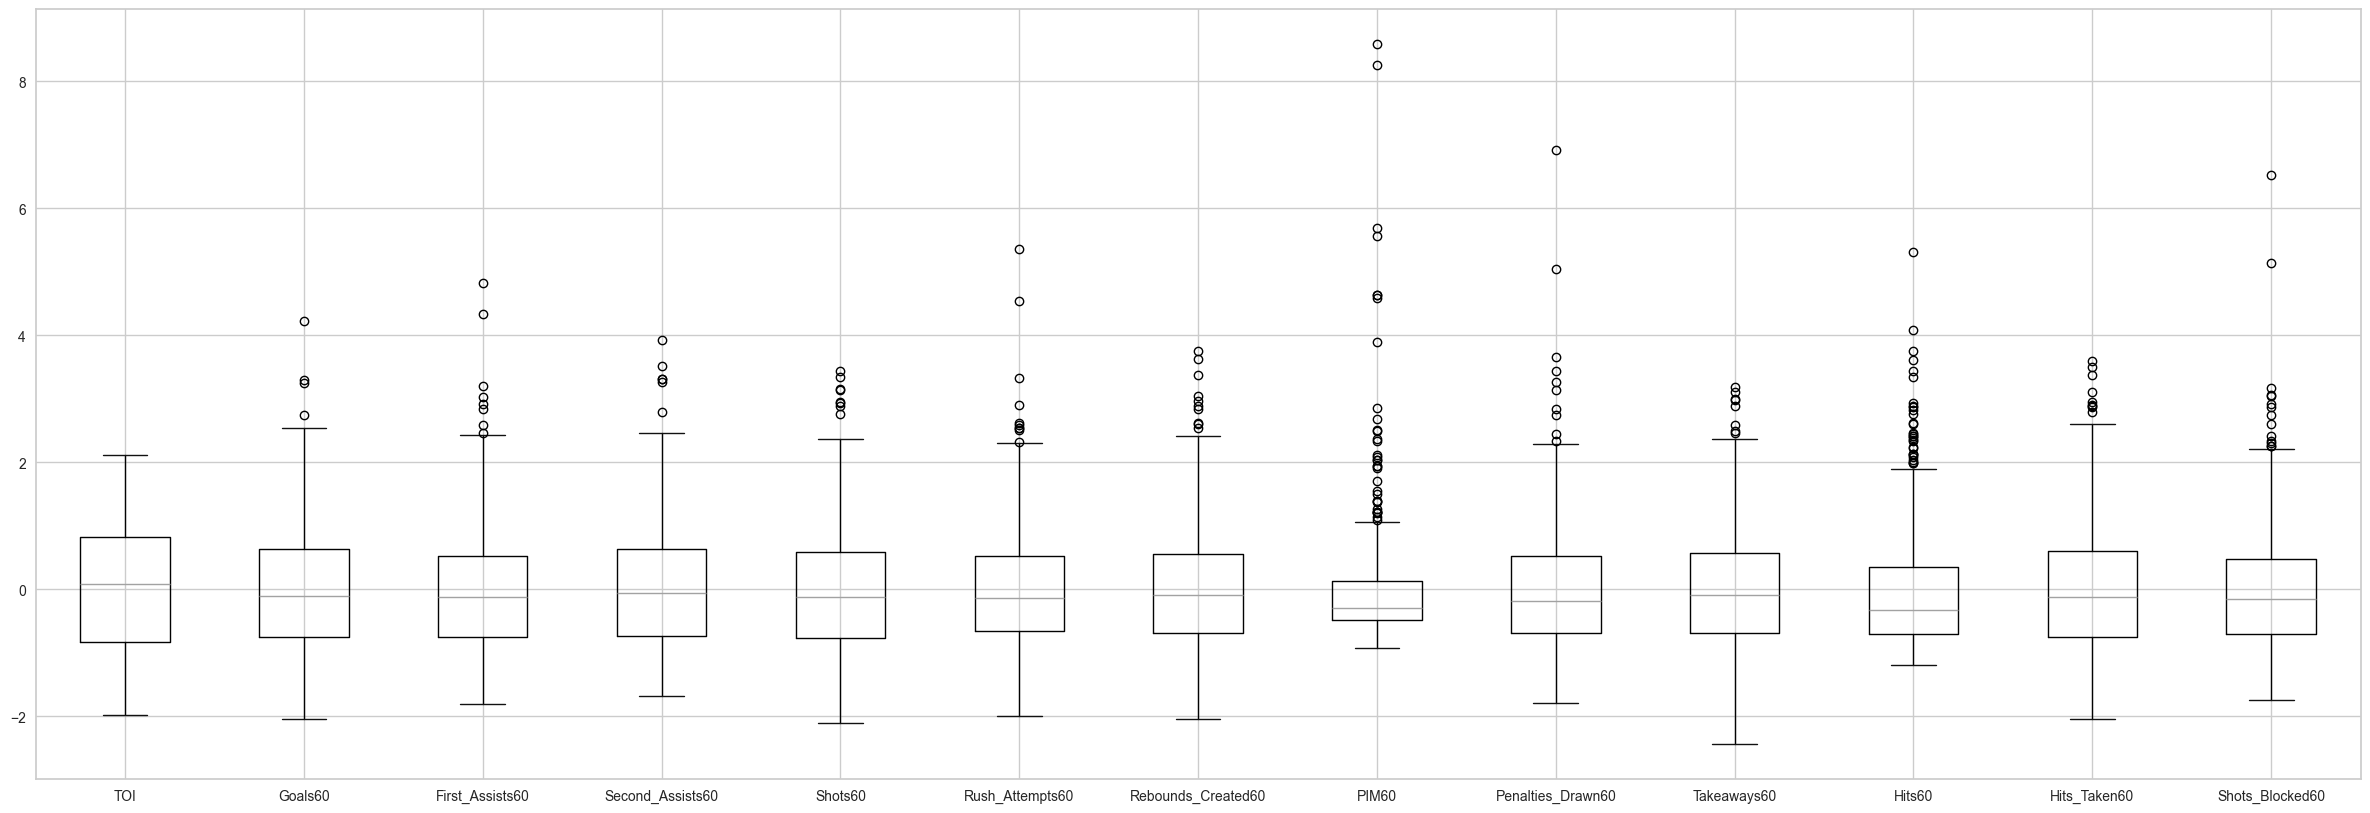

In [163]:
scaled_df.boxplot(figsize=(30,10));
plt.show()

From the features we selected, there does not appear to be any high degree of collinearity. Some features show a moderate degree of correlation, but all of these correlated features are <= 0.71 and represent different, though related things. For example, the greatest correlation is between Shots60 and Goals60 (0.71). It stands to reason that more shots will likely result in more goals, but higher goals in fewer shots may represent a more talented shooter.

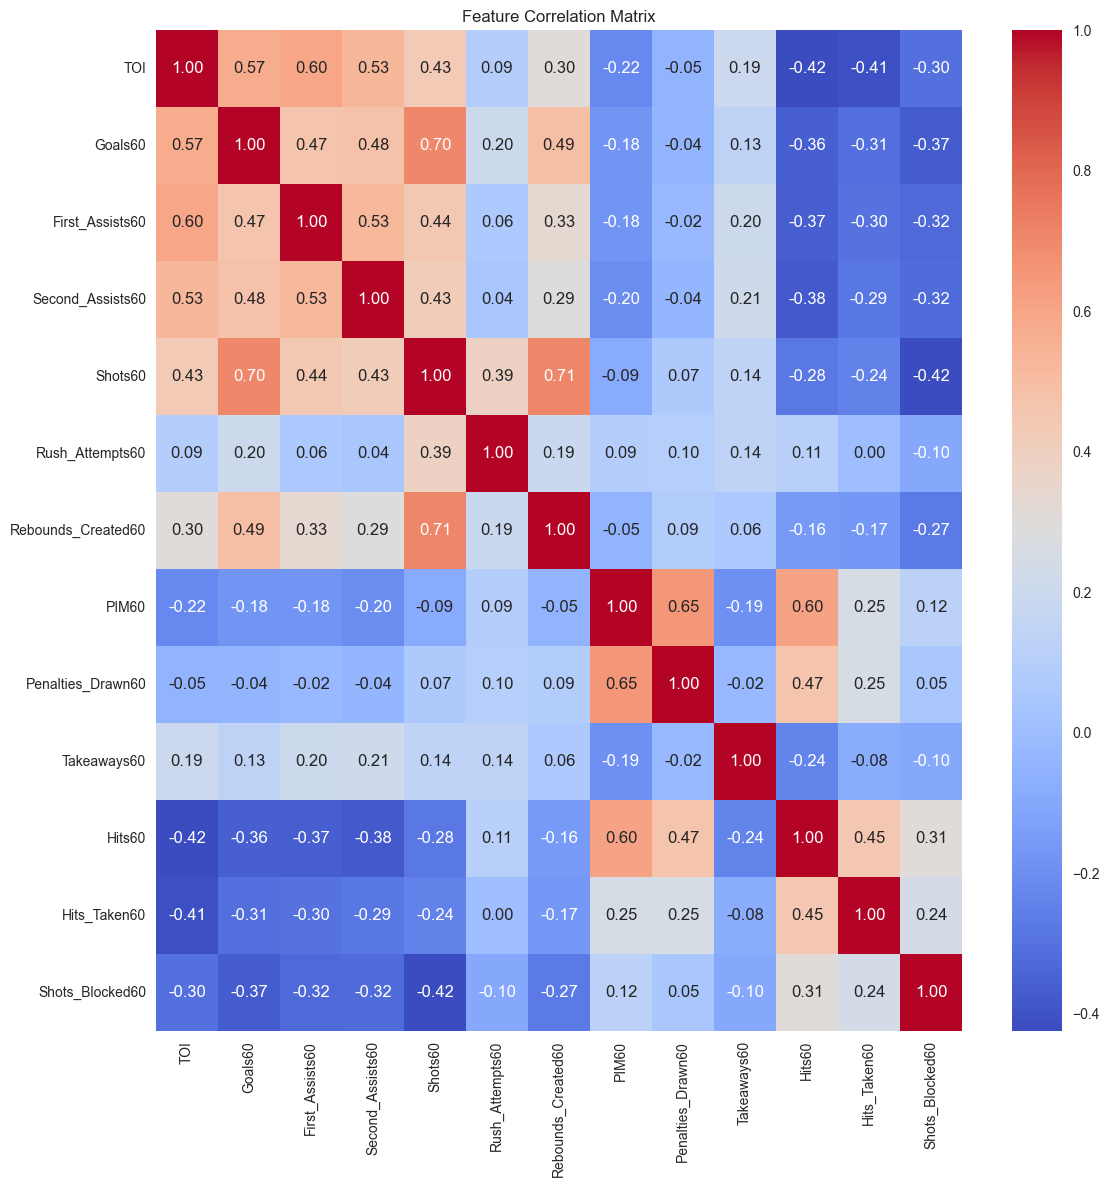

In [164]:
plt.figure(figsize=(13,13))
sns.heatmap(scaled_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

This is supported by a pairwise plot of all features which suggests some mild correlations at most. This low collinearity supports our use of all selected features without needing dimensionality reduction for redundancy.

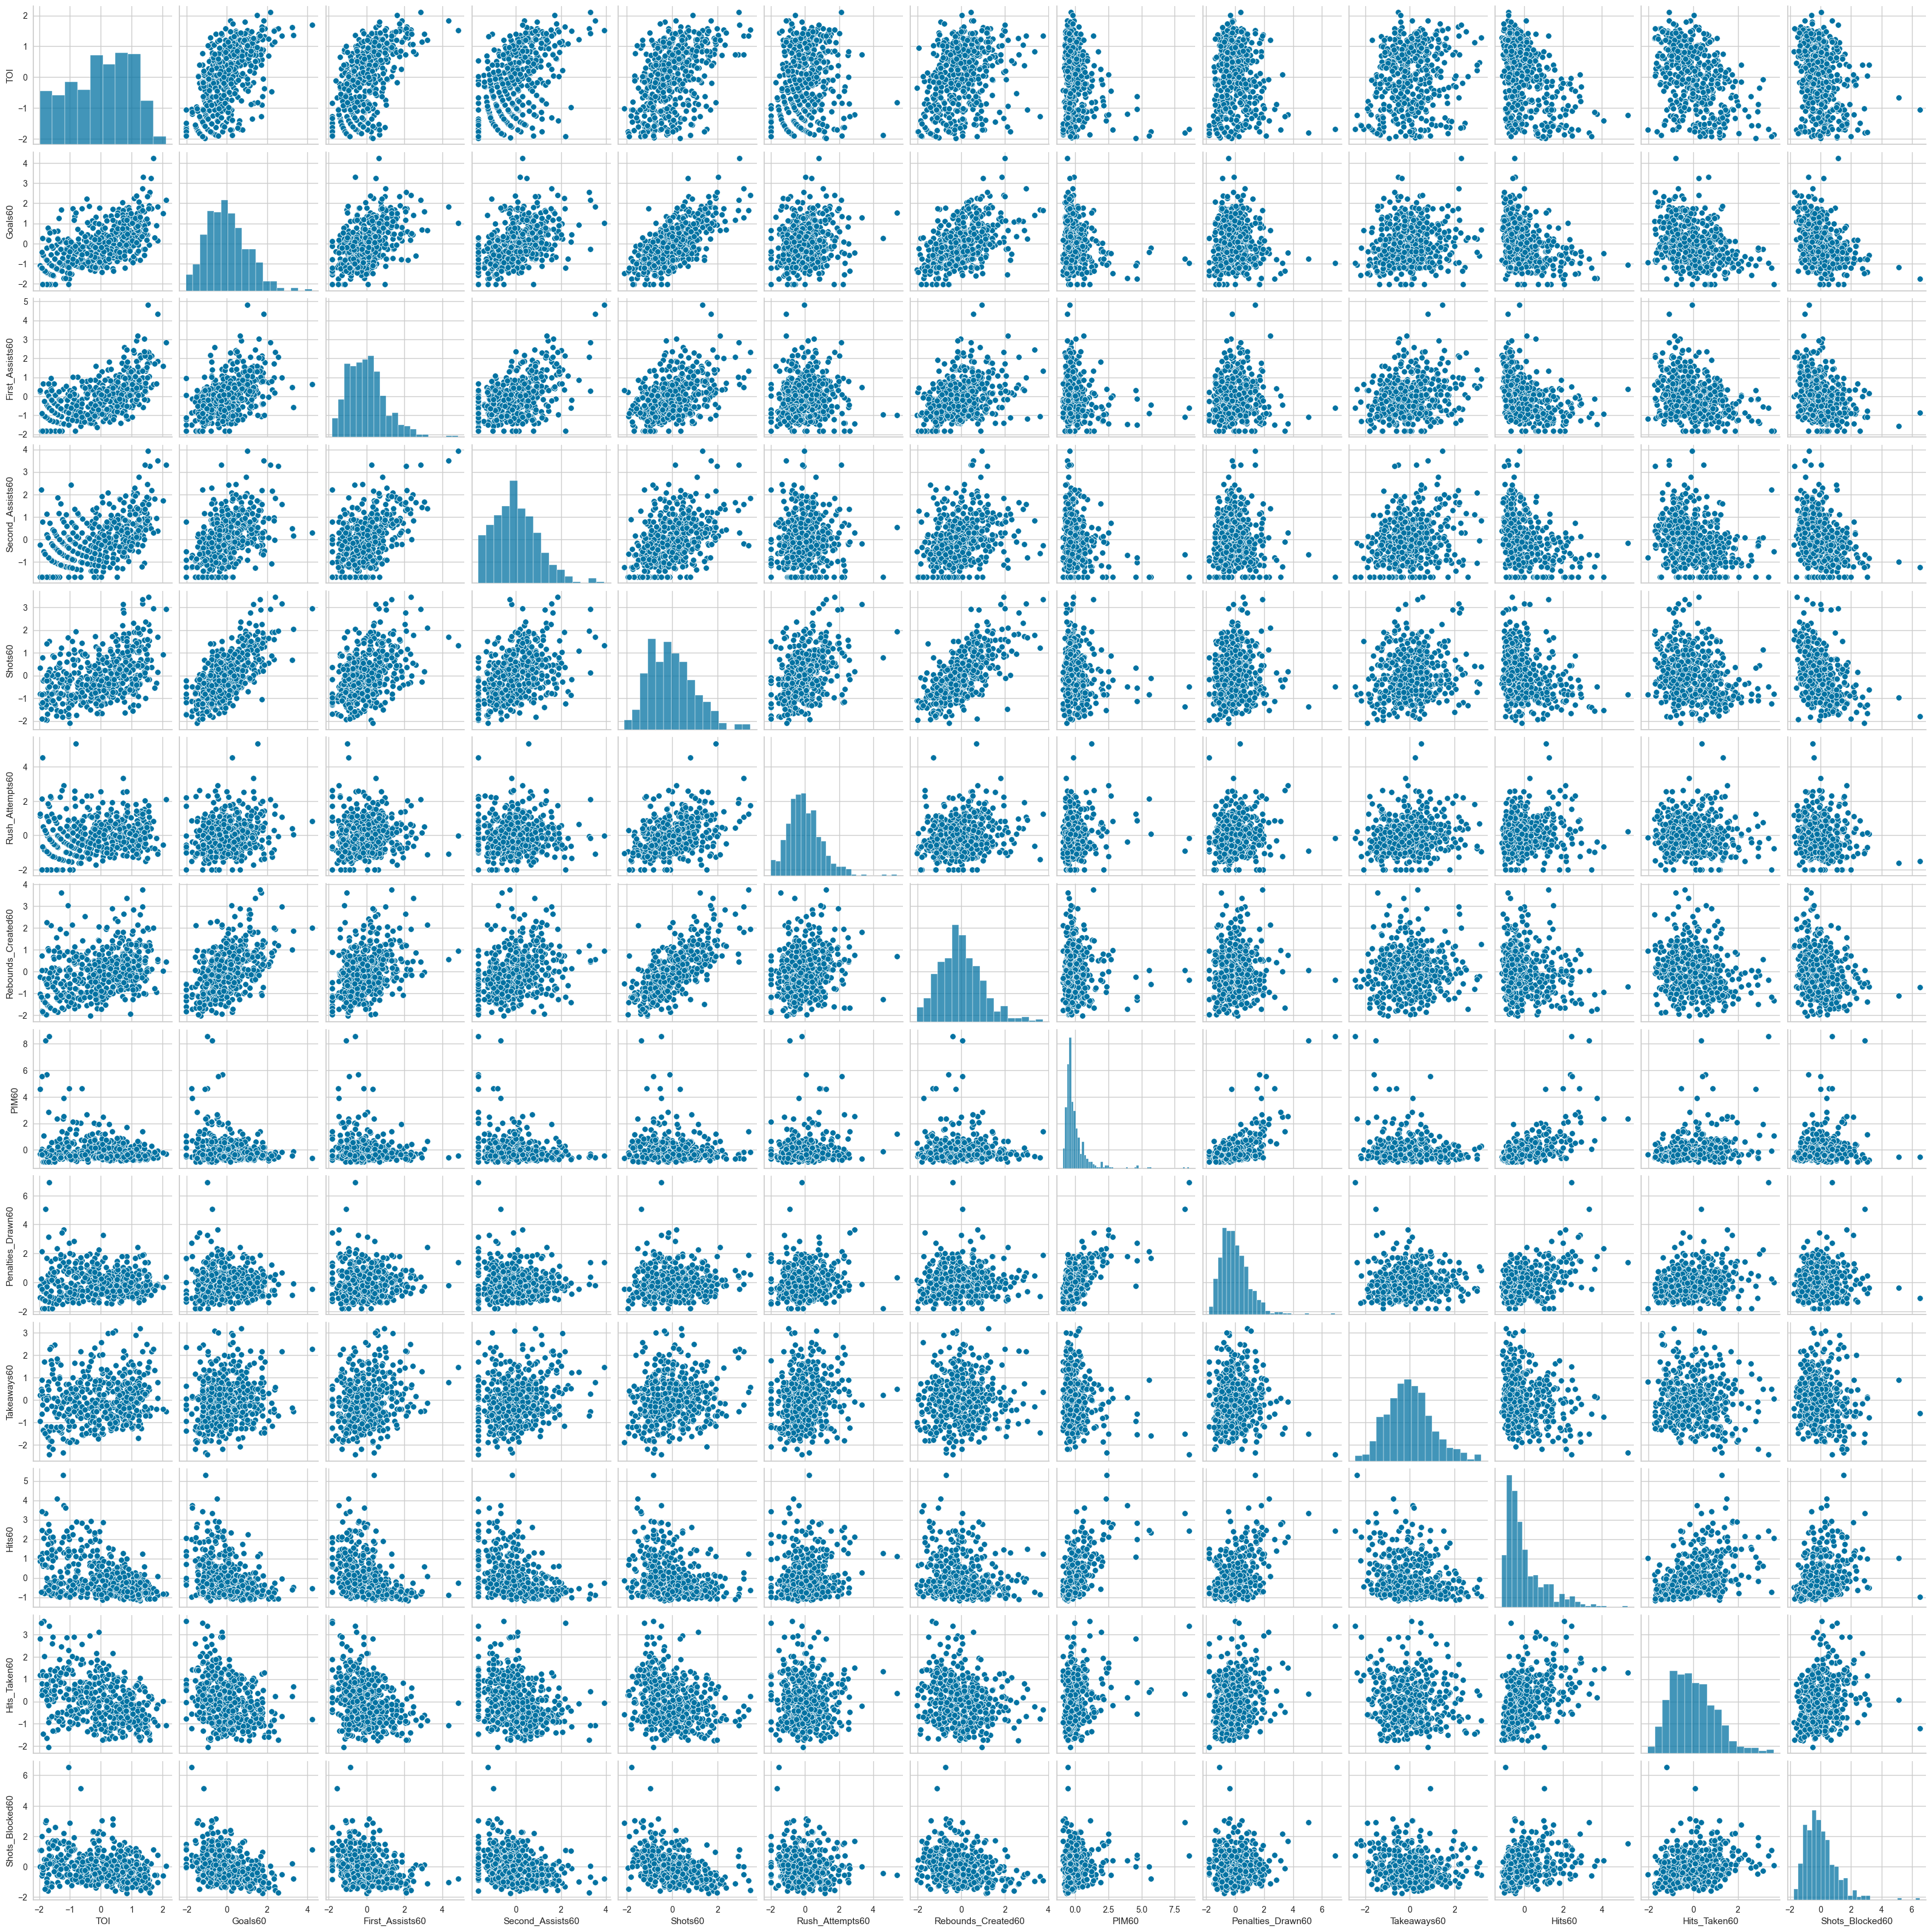

In [165]:
sns.pairplot(scaled_df[cluster_features]);
plt.show()

We applied a t-SNE (t-Distributed Stochastic Neighbor Embedding) to attempt to visualize our high dimension data in two dimensions to see if there is any evident cluster pattern. This dimensionality reduction technique attempts to preserve higher dimensional distances in a 2 dimensional space and can potentially reveal groups or patterns in our higher dimensional data. Unfortunately in this case no obvious pattern emerges just yet.

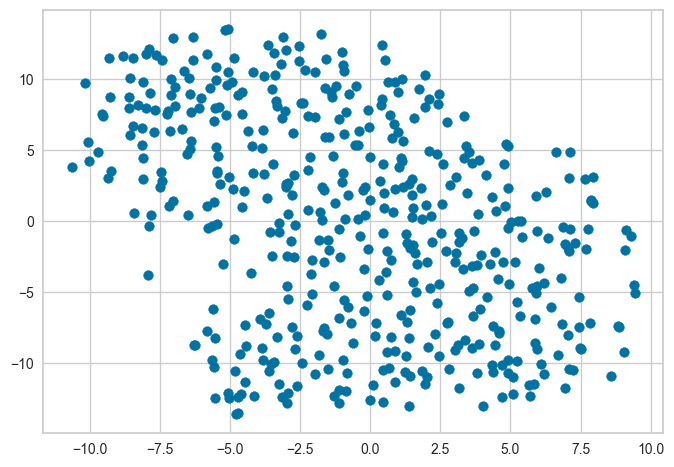

In [166]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(perplexity=50, random_state=42)
tsne_data = tsne.fit_transform(scaled_df)

# Extract t-SNE components
x = tsne_data[:,0]
y = tsne_data[:,1]

plt.scatter(x,y)
plt.show()


## KMeans Clustering

KMeans was selected as the primary model type because it minimizes within-cluster variance, making it effective for grouping players in higher-dimensional space. After clustering, we will examine the characteristics of each group to understand what player types they represent.

### Hyperparameter Tuning

Since we will be using a KMeans model to cluster our data, we used KElbowVisualizer. This runs KMeans with multiple values of K and attempts to determine the ideal value of K, where increasing the number of clusters doesn't significantly improve performance. In our case, we tested values of K from 3 to 10. The best value of K in this range was 5.

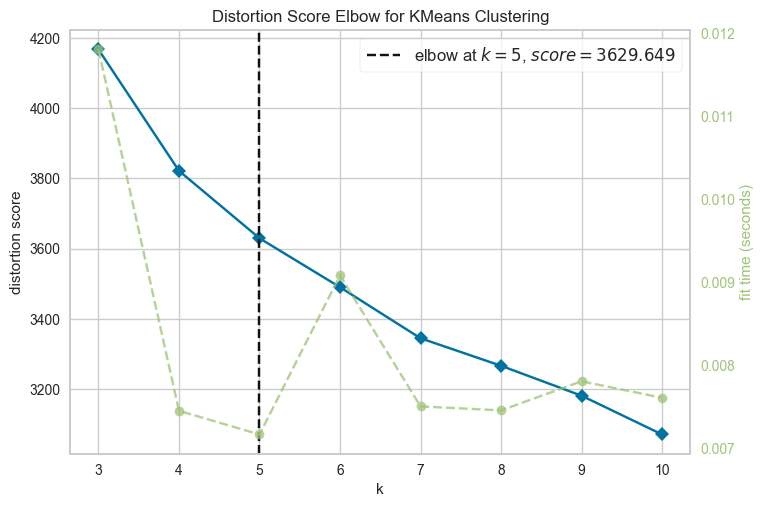

In [167]:
elbow = KElbowVisualizer(KMeans(random_state=42), k=(3,11))
elbow.fit(scaled_df)
elbow.show();

### Model

Using the K or n_clusters value identified by our K-Elbow, we used sklearn's KMeans to cluster our player data.

In [168]:
n_clusters = elbow.elbow_value_
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_df)
player_df['KMeans'] = clusters

### Analysis

A bar plot of the number of players in each cluster shows us an uneven distribution of players with the largest cluster, cluster 4, containing just under 175 players and the smallest, cluster 3, with only about 35. This is to be expected for clustering highly complex sports statistics. Grouping players by types, there are without a doubt some categories that would be much smaller than others. Cluster 4 may represent a broad category of players with average statistics whereas cluster 3 may identify a more niche player type with a specialized role.

C:\Users\coach\AppData\Local\Temp\ipykernel_26588\82010150.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


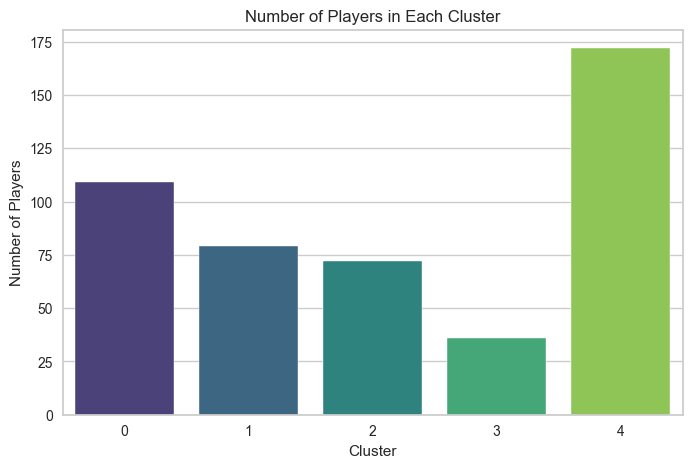

In [169]:
# Create a DataFrame for cluster counts
cluster_counts = pd.Series(clusters).value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Number of Players")
plt.title("Number of Players in Each Cluster")
plt.xticks(rotation=0)

plt.show()

We re-examined our t-SNE from above, but with the clusters color-coded. While there is some overlap in the 2 dimensional representation, the clusters do seem to be moderately well-defined in this space, suggesting that KMeans was able to pick up on some underlying patterns in the feature space.

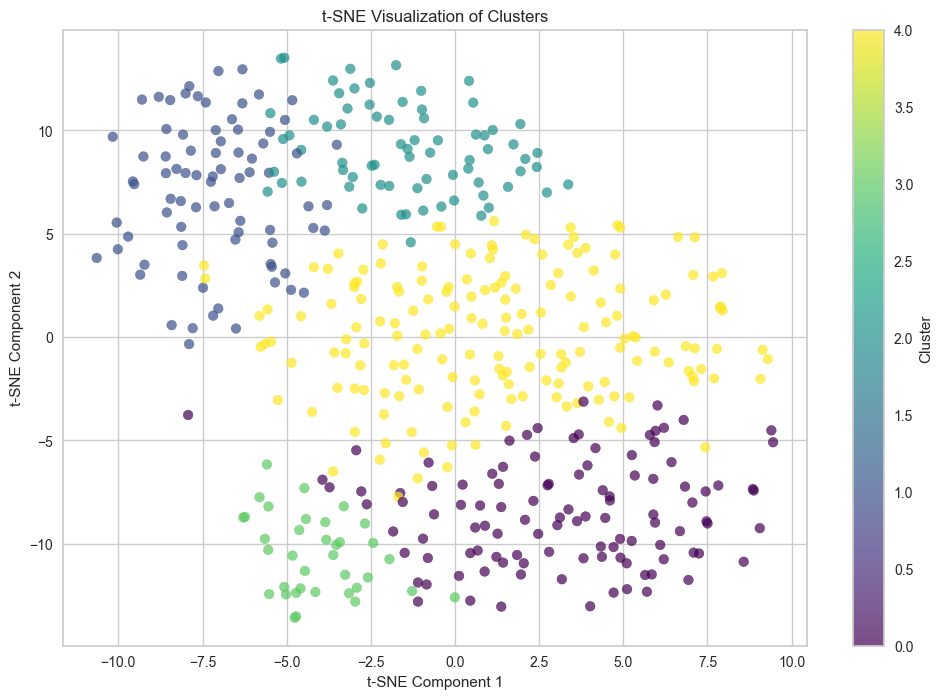

In [170]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(perplexity=50, random_state=42)
tsne_data = tsne.fit_transform(scaled_df)

# Extract t-SNE components
x = tsne_data[:,0]
y = tsne_data[:,1]

# Scatter plot with cluster-based colors
plt.figure(figsize=(12,8))
plt.scatter(x, y, c=clusters, cmap='viridis', alpha=0.7)  # Color by cluster
plt.colorbar(label='Cluster')  # Show color legend
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In order to assign meaningful labels to our clusters, we examined the distribution of each feature across each cluster. By analyzing these distributions, we can begin to understand which player statistics differentiate the clusters, enabling us to assign meaningful labels in the following results section.

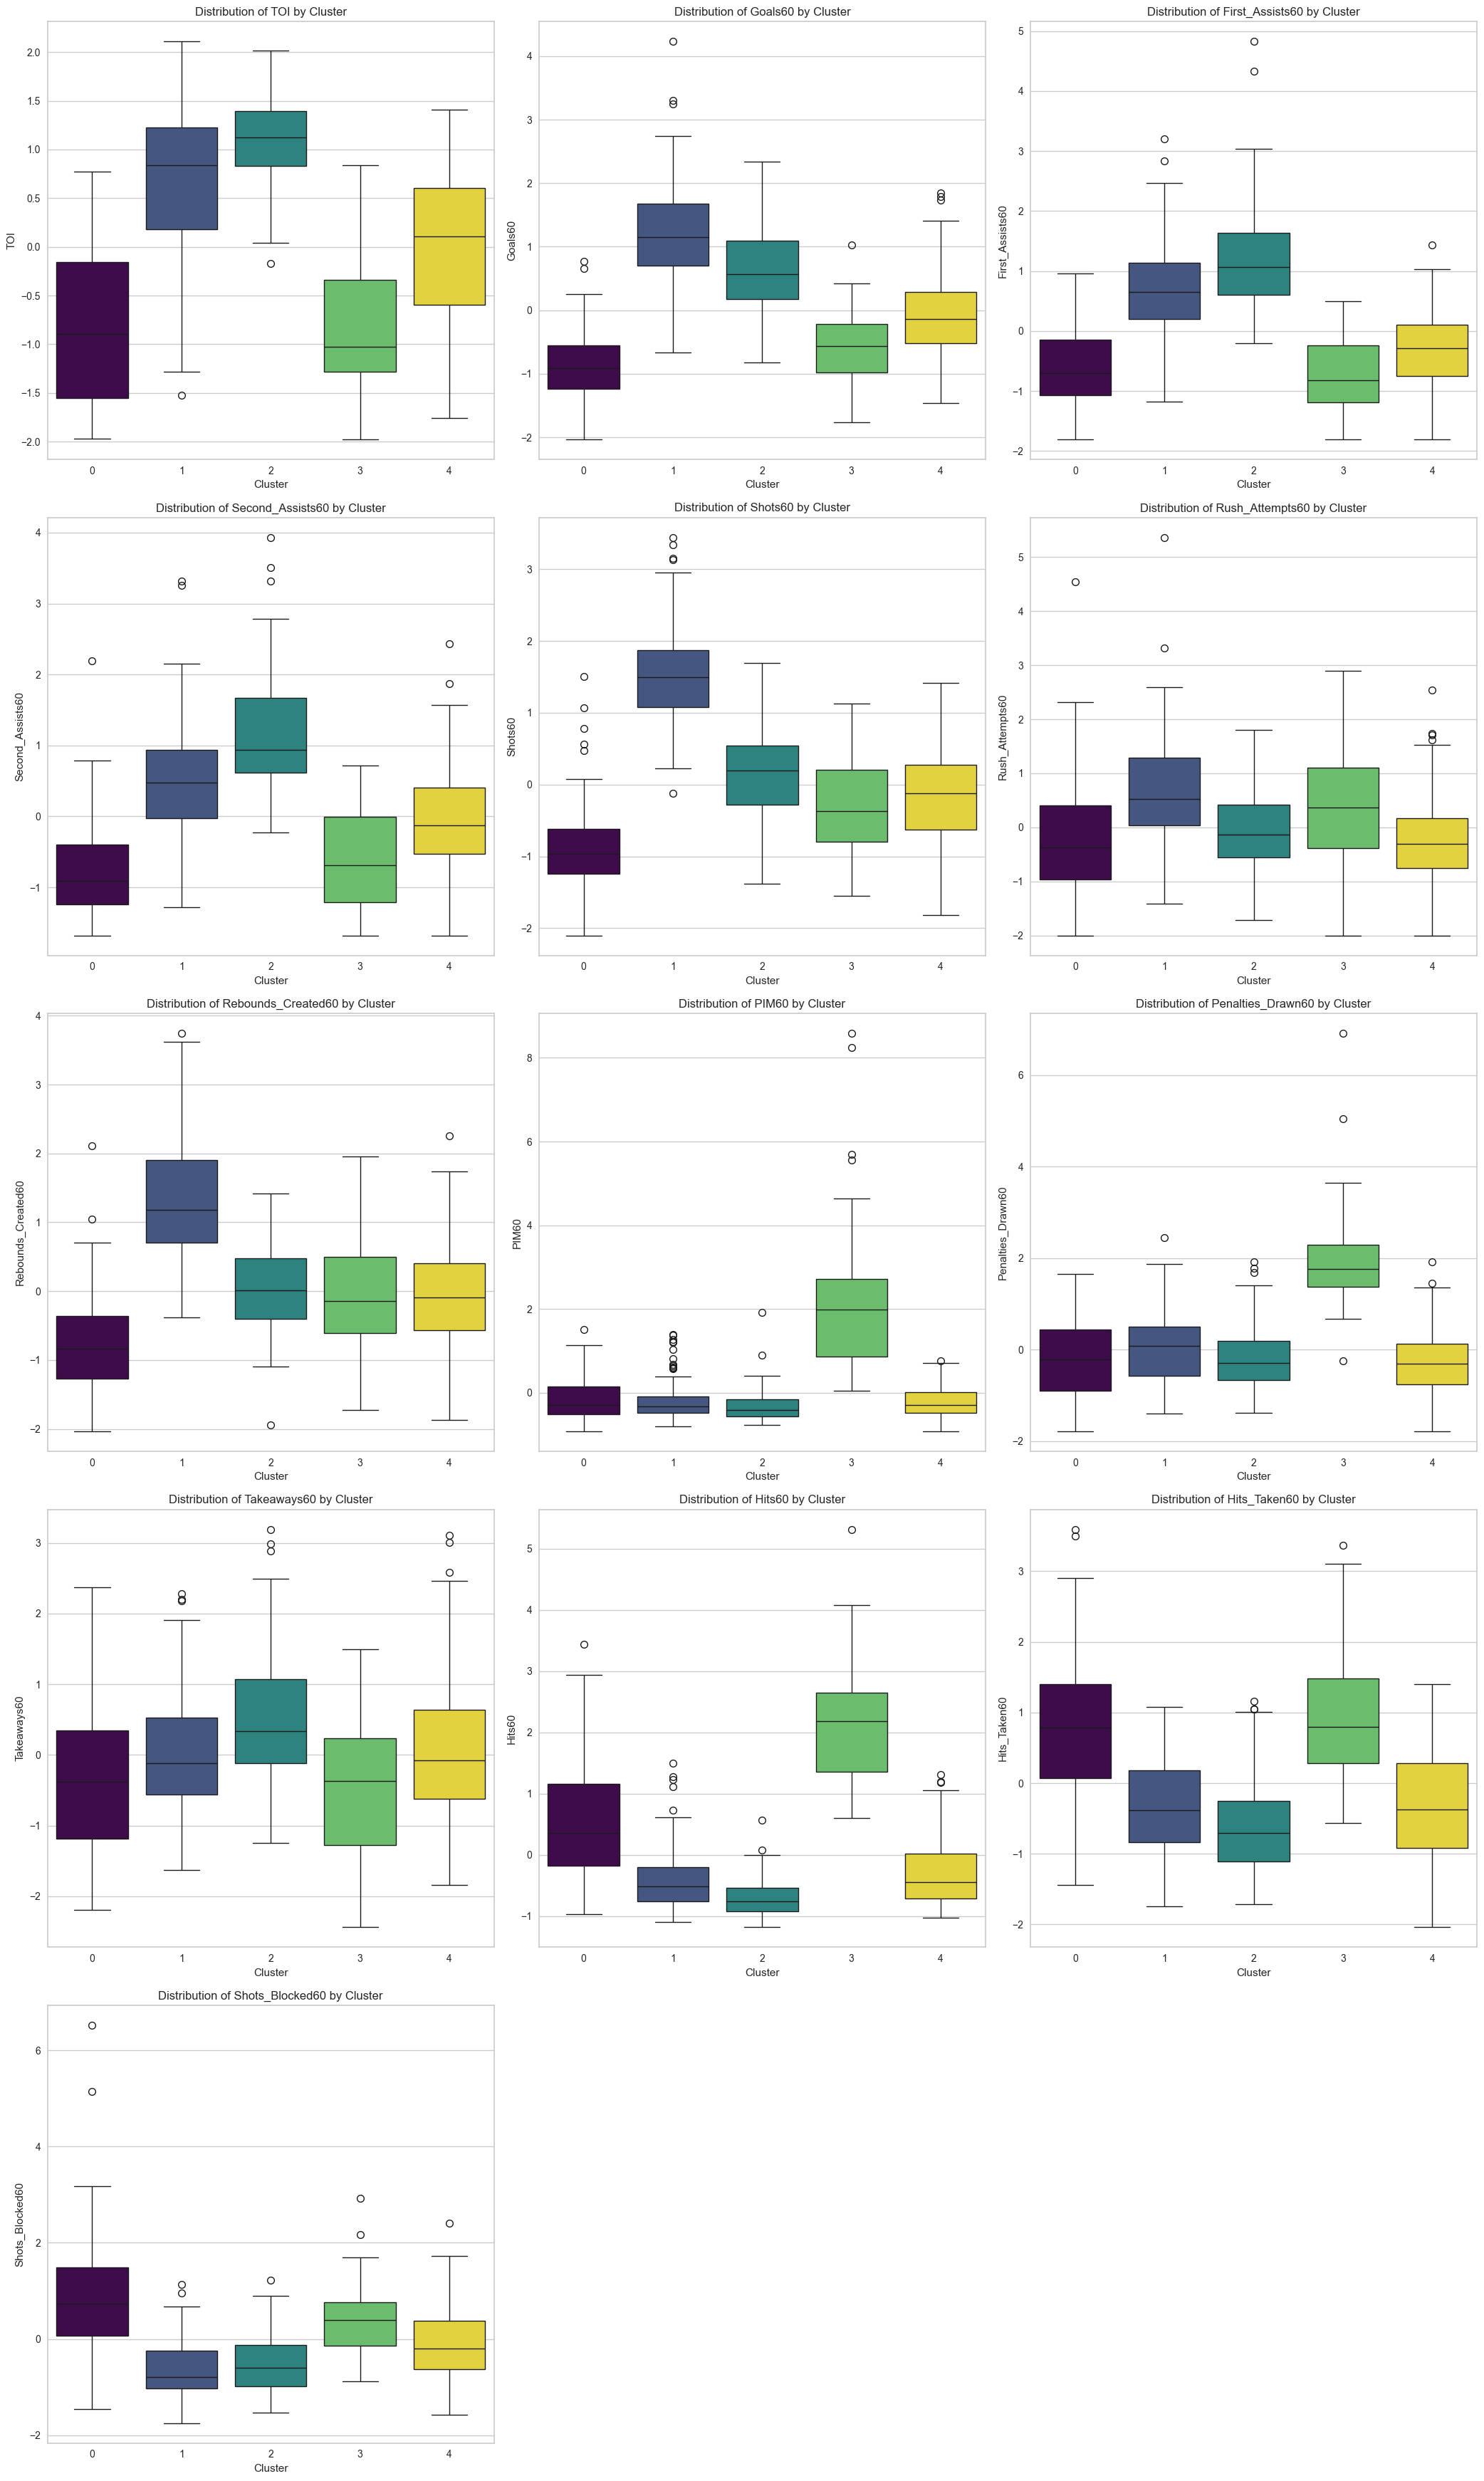

In [171]:
num_features = len(scaled_df.columns)
cols = 3  # Columns per row
rows = math.ceil(num_features / cols) # Number of rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 7))
axes = axes.flatten()

for idx, feature in enumerate(scaled_df.columns):
    sns.boxplot(
        data=scaled_df, 
        x=clusters, 
        y=feature, 
        ax=axes[idx], 
        hue=clusters, 
        palette="viridis", 
        legend=False
    )
    axes[idx].set_title(f"Distribution of {feature} by Cluster")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel(feature)

# If extra space, remove unused axes
for idx in range(num_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

### Results

Our K-elbow analysis indicated that five clusters are optimal within our test range. The KMeans model separated the data into five distinct clusters. By examining the distribution of key statistics across these clusters, we assigned each a meaningful verbal label along with a short description that highlights the traits driving its separation.

- Cluster 0 – Defensive Specialists:
These players show lower offensive outputs—such as lower goals, assists, and scoring chance metrics—compared to the other clusters. However, their higher rates of shot-blocking suggest a focus on defensive responsibilities. This cluster likely represents players who focus on protecting the defensive zone and limiting opponents’ opportunities.

- Cluster 1 – Shooters:
This group is marked by the highest counts in shots, goals, and rebounds. Their statistical profile indicates a primary focus on scoring, with an aggressive approach in front of the net. These players are clearly geared toward generating offensive opportunities and finishing plays.

- Cluster 2 – Playmakers:
Characterized by standout assist numbers, the players in this cluster lean toward setting up their teammates rather than scoring themselves. Their elevated assist totals underscore a creative role focused on distribution rather than finishing plays themselves.

- Cluster 3 – Physical Forwards/Enforcers:
Distinguished by noticeably lower offensive outputs (both goals and assists), this group compensates with elevated physicality, as evidenced by higher penalty minutes (PIM) and a higher rate of hits. These players embrace a tougher, more physical style of play—playing the role of enforcers or checking specialists who are relied upon for their grit and toughness.

- Cluster 4 – Two-Way Forwards:
Representing the largest group, these players exhibit balanced statistical characteristics. They do not stand out in any single offensive or defensive area but contribute steadily across both ends of the ice. This versatile profile suggests that they are relied upon to perform in multiple roles, acting as consistent and adaptable forwards.

## Other Models

In this section, we explore alternate clustering methodologies to evaluate the robustness of our clustering strategy. By comparing methods, we can assess whether the groupings we see with KMeans are consistent when alternative techniques or dimensionality reduction are used.

### Agglomerative Clustering

For consistency with our KMeans setup, we use the same value of n_clusters when applying Agglomerative Clustering. We used the Ward linkage method, which seeks to minimize the within-cluster variance in a hierarchical fashion.

In [172]:
agg = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
clusters =agg.fit_predict(scaled_df)
player_df['AggClust'] = clusters

### PCA + Clustering

Since our datasets are high-dimensional, we implement PCA as a way to reduce the number of variables while retaining at least 90% of the original variance. After applying PCA, we perform clustering in the reduced space using two techniques:
- PCA + KMeans:
The PCA-transformed data is clustered using KMeans, ensuring that the dimensionality reduction doesn't substantially alter our clustering structure.
- PCA + Agglomerative Clustering:
We also run Agglomerative Clustering on the PCA-reduced data. This allows us to observe if similar groupings occur when using hierarchical approaches on a more compact feature set.

In [173]:
pca = PCA(n_components=0.9, random_state=42)
scaled_pca = pca.fit_transform(scaled_df)

print(pca.explained_variance_ratio_)
print(f"PCA identified {pca.n_components_} components for {sum(pca.explained_variance_ratio_)*100:.0f}% of variance.")

[0.34109086 0.16494215 0.08379696 0.07905832 0.05928101 0.05812162
 0.05066026 0.03748393 0.03602399]
PCA identified 9 components for 91% of variance.


In [174]:
pkmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = pkmeans.fit_predict(scaled_pca)
player_df['PCA_KMeans'] = clusters

In [175]:
pagg = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
clusters = pagg.fit_predict(scaled_pca)
player_df['PCA_AggClust'] = clusters

### Analysis

#### Cluster Alignment

Before comparing the results of the different clustering techniques, we need to align their resulting clusters. This is because the clusters labels (0.., n_clusters) are assigned arbitrarily so KMeans cluster 1 could theoretically match perfectly with AggClust 3. We optimize the matching of the clusters using the Hungarian algorithm.

In [176]:
# Align the cluster assignments in the DataFrame

cluster_columns = ["KMeans", "AggClust", "PCA_KMeans", "PCA_AggClust"]
clusters_df = player_df[cluster_columns].copy() # Pandas gives an error if we use the original dataframe

def align_clusters(model1, model2):
    # Hungarian Algorithm to find optimal mapping
    contingency_matrix = pd.crosstab(clusters_df[model1], clusters_df[model2])
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)  # Negative for minimum difference

    # Map cluster labels
    mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}
    return mapping

# Align all other models tou our primary KMeans clusters
for model in ['AggClust', 'PCA_KMeans', 'PCA_AggClust']:
    mapping = align_clusters("KMeans", model)
    clusters_df.loc[:, model] = clusters_df[model].map(mapping).astype('int32')

# Insert mappings into original dataframe
player_df[cluster_columns] = clusters_df[cluster_columns]

#### Measuring pairwise similarity

We checked the similarity between our primary KMeans clustering assignment and each of the other clustering methods attempted. Since there are no ground truth labels in our project, we used the Normalized Mutual Information (NMI) metric to evaluate similarity between two clusters. NMI measures the mutual dependence between clustering assignments, ensuring that the results are comparable even in the absence of predefined class labels. A high NMI score indicates strong alignment between clustering assignments, meaning that different clustering methods produce similar clusters.


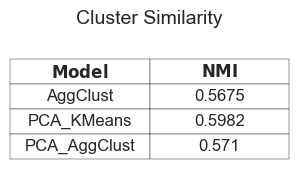

In [177]:
# Measure similarity of cluster assignments
scores = []
for cluster_type in ['AggClust', 'PCA_KMeans', 'PCA_AggClust']:
    v_score = v_measure_score(player_df['KMeans'], player_df[cluster_type])
    scores.append((cluster_type, v_score))

cluster_sim = pd.DataFrame(scores, columns=['Model', 'NMI'])

# Print a table of the NMI for each model
fig, ax = plt.subplots(figsize=(3, 2))
ax.set_axis_off() 

table = ax.table(cellText=cluster_sim.round(4).values, 
                 colLabels=[f"$\\bf{{{col}}}$" for col in cluster_sim.columns], # column headers in bold
                 cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)  # Adjust cell size
plt.title("Cluster Similarity", fontsize=14, loc="center")
plt.show()

### Results

We compared four approaches: the primary KMeans clustering, Agglomerative Clustering, PCA + KMeans, and PCA + Agglomerative Clustering. After aligning clusters with the Hungarian algorithm, we assessed pairwise similarity using the Normalized Mutual Information (NMI) metric.

Our results suggest that the PCA_KMeans model most closely mirrors the cluster structure discovered by standard KMeans, with an NMI of 0.598, although all of the models have very similar NMI values with respect to our KMeans model (0.568-0.598). This suggests that the hierarchical methods may have discovered somewhat different structures within the player data. Despite this an NMI of near 0.6 is a moderately good alignment with the primary KMeans model, especially given the fuzzy nature of sports data. The slight deviations may stem from the nature of the algorithms: while KMeans emphasizes spherical clusters and global variance minimization, Agglomerative Clustering captures local structure in a bottom-up fashion, which may lead to divergences in how certain edge-case players are grouped. Additionally, the use of PCA introduces a transformation of the feature space that could lead to slightly different cluster boundaries in the reduced-dimensional space.

## Conclusion

<span style='font-size: 24px;'>***KMeans Clustering Model***</span>

In this project, we applied unsupervised learning techniques to cluster NHL forwards from the 2023–24 season based on a wide array of in-game performance metrics. Our primary model, KMeans clustering, identified five distinct player types:

  - Defensive Specialists, who prioritize blocking shots and limiting opponents' scoring chances,

  - Shooters, who generate high shot volume and goal totals,

  - Playmakers, who lead in assists and excel at setting up teammates,

  - Physical Forwards/Enforcers, who contribute less offensively but bring high physical intensity,

  - Two-Way Forwards, who show a well-rounded balance across all areas.

These clusters align well with intuitive playing styles seen in professional hockey and provide interpretable, role-based groupings that coaches, analysts, or scouts might find useful.

<span style='font-size: 24px;'>***Other Clustering Models***</span>

  To evaluate the robustness of our findings, we compared KMeans to Agglomerative Clustering and two PCA-based variants. Using Normalized Mutual Information (NMI) as our similarity metric, we found that the PCA-based KMeans clustering most closely aligned with our primary model (NMI = 0.60), while Agglomerative Clustering showed slightly lower agreement (NMI ≈ 0.57), both with and without PCA.

  These modest differences suggest that while the core clustering structure keeps some consistency across models, edge cases may be grouped differently depending on the clustering algorithm used. Additionally the PCA transformation somewhat alters the geometry of the data, which seems to slightly affect cluster boundaries. The observed variation in these models signifies that different algorithms may emphasize different aspects of player behavior.

<span style='font-size: 24px;'>***Limitations***</span>

  While our clustering analysis yielded interpretable player groupings, there are several important caveats and constraints to keep in mind:

  1. **Single‐Season, Forward‐Only Scope**: We used only one season of NHL data (2023–24) and restricted our analysis to forwards. Player performance can vary substantially from year to year so clusters found here may not generalize to other seasons or to defensemen.

  2. **Model Selection**: We limited our study to K-Means and Agglomerative Clustering, the methods with which we’re most familiar. Other algorithms (e.g., density-based, spectral clustering) might uncover more nuanced groupings or better capture rare player archetypes.

  3. **Lack of External Validation**: Clusters were not cross-checked against expert labels or coaching roles. Therefore, there’s no guarantee that every player in a given cluster would be recognized as that “type” by hockey analysts or scouts.

<span style='font-size: 24px;'>***Future Research***</span>

  In terms of future study to extend this project, there are a number of potentially interesting avenues:

  1. **Temporal analysis**: Track how player cluster assignments change over time, either within a season or across multiple seasons.

  2. **Incorporate goalie and defensemen data**: For this study we limited the scope to forwards, but it would be interesting to expand the analysis to include other positions and understand how their playing styles cluster differently.

  3. **Role projection for prospects**: Apply the clustering model to junior league or lower league players to project potential NHL roles based on similar statistical profiles.


## References

Dataset:
"Player Season Totals". *Natural Stat Trick*. 2024. https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=S&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL

GitHub Repository:

